In [33]:
import math
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline
# Display preferences.
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [34]:
# Load data
crime_ny = pd.read_excel('/Users/justinsmith/Documents/GitHub/NY2013crime.xls', header=4, skipfooter=3)

In [35]:
# Clean columns, outliers, and nan
crime_ny[crime_ny['Population'] > 1000000]
# crime_ny = crime_ny.drop([0,216])
crime_ny = crime_ny.drop(crime_ny.columns[4], axis=1)
crime_ny.columns = ['City', 'Pop', 'Violent', 'Murder', 'Rape', 'Robbery', 'Assault', 'Property', 'Burglary', 'Larceny', 
                    'MVtheft', 'Arson']
crime_ny.head()

,City,Pop,Violent,Murder,Rape,Robbery,Assault,Property,Burglary,Larceny,MVtheft,Arson
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,30,227,526,4090,705,3243,142,nan
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,nan


In [36]:
# create features for linear regression
crime_ny['pop_sq'] =crime_ny['Pop']**2
crime_ny['murder_bool'] = crime_ny['Murder'].astype(bool)
crime_ny['rob_bool'] = crime_ny['Robbery'].astype(bool)
crime_ny['burg_bool'] = crime_ny['Burglary'].astype(bool)
crime_ny['arson_bool'] = crime_ny['Arson'].astype(bool)

In [38]:
# start shaping data for regression
regr = linear_model.LinearRegression()
Y = crime_ny['Property'].values.reshape(-1,1)
X = crime_ny[['Pop','pop_sq','murder_bool', 'rob_bool', 'burg_bool', 'arson_bool']]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [39]:
# look at data
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 3.46494748e-02 -2.11021718e-09  1.11405733e+01 -9.21119642e+01
  -8.95179729e+01  2.52529604e+01]]

Intercept: 
 [-42.8662706]

R-squared:
0.9961323165384894


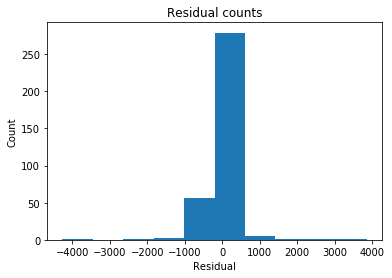

In [41]:
# plot the residual in a histogram
predicted = regr.predict(X).ravel()
actual = crime_ny['Property']
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

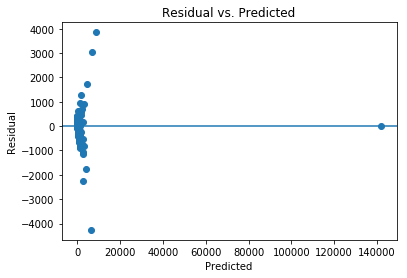

In [42]:
# plot prediction with residual
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [43]:
# Not very imformative.
# Check out the correlation matrix
correlation_matrix = X.corr()
display(correlation_matrix)

,Pop,pop_sq,murder_bool,rob_bool,burg_bool,arson_bool
Pop,1.000,0.998,0.162,0.064,0.022,0.057
pop_sq,0.998,1.000,0.133,0.044,0.014,0.042
murder_bool,0.162,0.133,1.000,0.313,0.103,0.250
rob_bool,0.064,0.044,0.313,1.000,0.286,0.373
burg_bool,0.022,0.014,0.103,0.286,1.000,0.297
arson_bool,0.057,0.042,0.250,0.373,0.297,1.000


/Users/justinsmith/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/justinsmith/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


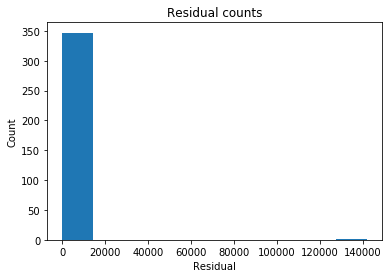

In [45]:
# scale the data to find a better fit
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scalerX = StandardScaler().fit(X)
scalerY = StandardScaler().fit(Y) 

normed_X = scalerX.transform(X)
normed_y = scalerY.transform(Y) 

normed_y = normed_y.ravel()
# Calculate a second residual with scaled data.
lr = linear_model.LinearRegression()
lr.fit(normed_X,normed_y)
predicted_2 = lr.predict(normed_X).ravel()
actual_2 = crime_ny['Property']
residual_2 = actual_2 - predicted_2

# This looks a bit concerning.
plt.hist(residual_2)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

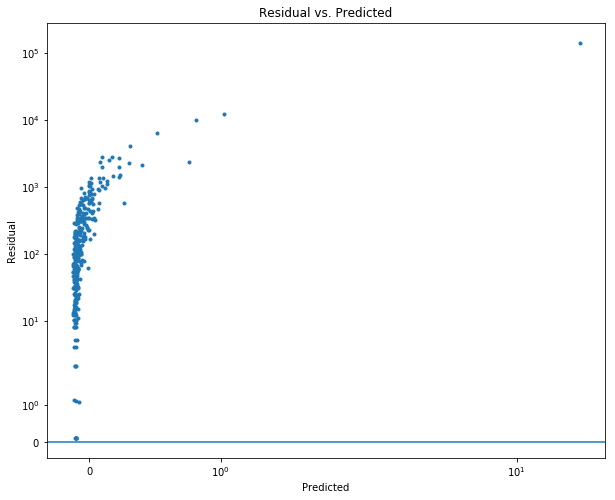

In [46]:
# plot residual and prediction again. Us log to help scale data more.
fig = plt.figure(111,figsize=[10,8])
ax = plt.gca()
ax.scatter(predicted_2, residual_2, marker='.')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.set_xlabel('Predicted')
ax.set_ylabel('Residual')
ax.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [47]:
# rerun equation factors
print('\nCoefficients: \n', lr.coef_)
print('\nIntercept: \n', lr.intercept_)
print('\nR-squared:')
print(lr.score(normed_X, normed_y))


Coefficients: 
 [ 2.03578574e+00 -1.04106196e+00  5.06609875e-04 -5.89832996e-03
 -2.78693115e-03  1.60431567e-03]

Intercept: 
 4.161414796618672e-17

R-squared:
0.9961323165384894


In [48]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [61]:
linear_formula = 'Property ~ Pop+pop_sq+Murder+Robbery+Burglary+Arson'
# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=crime_ny).fit()

In [62]:
print(lm.params)

Intercept   -34.360
Pop           0.014
pop_sq       -0.000
Murder      -15.274
Robbery      -2.382
Burglary      2.854
Arson        24.845
dtype: float64


In [63]:
print(lm.pvalues)

Intercept   0.005
Pop         0.000
pop_sq      0.006
Murder      0.188
Robbery     0.000
Burglary    0.000
Arson       0.000
dtype: float64


In [64]:
print(lm.rsquared)

0.9850716632961383


In [65]:
linear_formula_2 = 'Property ~ Pop+pop_sq+Robbery+Burglary+Arson'
# Fit the model to our data using the formula.
lm_2 = smf.ols(formula=linear_formula_2, data=crime_ny).fit()

In [66]:
print(lm_2.params)

Intercept   -33.877
Pop           0.014
pop_sq       -0.000
Robbery      -2.780
Burglary      2.849
Arson        22.331
dtype: float64


In [67]:
print(lm_2.pvalues)

Intercept   0.006
Pop         0.000
pop_sq      0.009
Robbery     0.000
Burglary    0.000
Arson       0.000
dtype: float64


In [68]:
print(lm_2.rsquared)

0.984927061232614
